INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._ebm:Estimating with FAST
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms


INFO:interpret.utils._unify_data:Unifying data
INFO:interpret.glassbox._ebm._bin:eval_terms


Best EBM model feature average importance is [0.17286131 0.03320313 0.01685962 0.03727546 0.06301069 0.05588154
 0.00652644 0.00594257 0.01393405 0.00791282 0.00712581 0.00662095]
Model saved as ebm_model.joblib


/scratch/cjiang1/job_32591390/ipykernel_3565496/1166999665.py:111: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/scratch/cjiang1/job_32591390/ipykernel_3565496/1166999665.py:112: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/home/cjiang1/miniconda3/envs/python3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/home/cjiang1/miniconda3/envs/python3.10/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



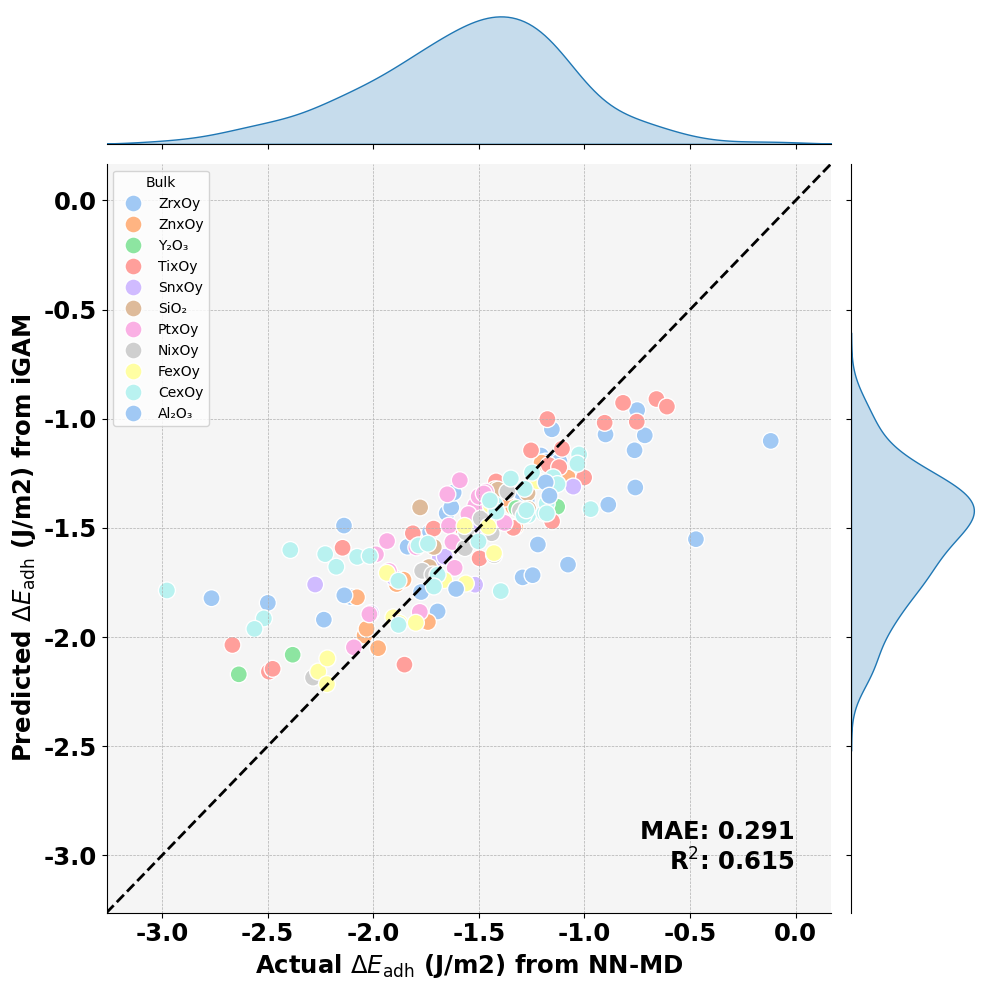

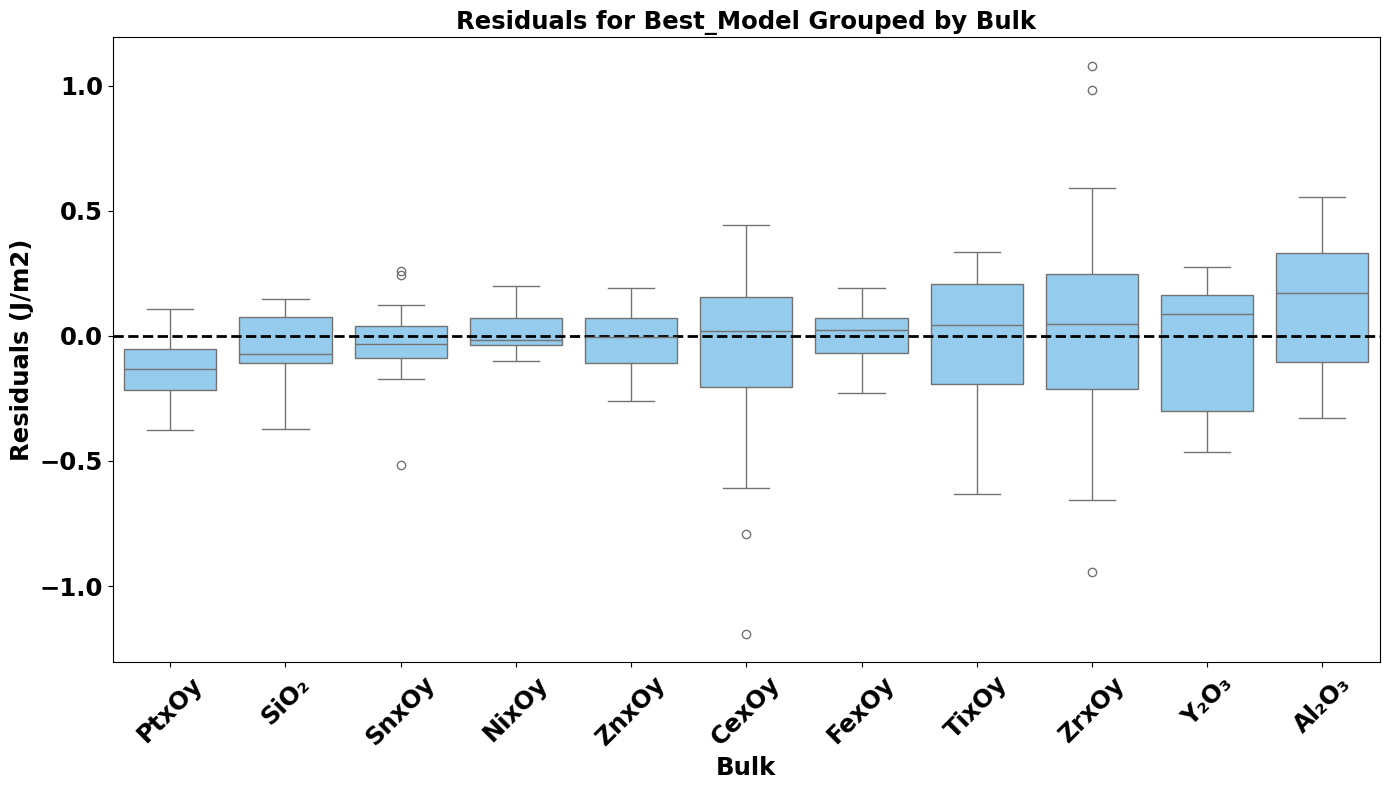

Complete!


In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from matplotlib.lines import Line2D
from joblib import dump, load  # 导入 joblib 的 dump 和 load 函数
set_visualize_provider(InlineProvider())
import logging
#Setup logging
logging.basicConfig(level=logging.INFO)
set_visualize_provider(InlineProvider())
get_ipython().run_line_magic('config', 'IPCompleter.greedy=True')

# 1. Load the data and prepare it for training
data = pd.read_csv("Total_set.csv")
data["Bulk"] = data["Bulk"].str.split("_").str.get(0)
subscript_map = {
    '0': '₀', '1': '₁', '2': '₂', '3': '₃', '4': '₄', '5': '₅',
    '6': '₆', '7': '₇', '8': '₈', '9': '₉'
}

def to_subscript(s):
    return ''.join(subscript_map.get(c, c) for c in s)

data["Bulk"] = data["Bulk"].apply(to_subscript)

#feature_names = ["E_surf.", "WF", "Ra", "NC_postive", "NC_negative", "Dipole_Z", "rho_O", "rho_M", "M_SBO", "O_SBO"]
feature_names = ["E_surf.", "Ra", "rho_O", "rho_M", "Ef", "Ehull"]
X = data[feature_names]
y = data["E_adh"]

# 2. Train the final EBM model using the best hyperparameters


# NCV_4 
#best_hyper = {'smoothing_rounds': 0, 'outer_bags': 1, 'min_samples_leaf': 20, 'max_rounds': 1000, 'max_leaves': 20, 'max_interaction_bins': 8, 'max_bins': 8, 'learning_rate': 0.001, 'inner_bags': 4, 'early_stopping_tolerance': 0.0001, 'early_stopping_rounds': 5}
# NCV_5
#best_hyper =  {'smoothing_rounds': 100, 'outer_bags': 5, 'min_samples_leaf': 20, 'max_rounds': 1000, 'max_leaves': 20, 'max_interaction_bins': 8, 'max_bins': 8, 'learning_rate': 0.001, 'inner_bags': 4, 'early_stopping_tolerance': 0.0001, 'early_stopping_rounds': 100}
# NCV_1
best_hyper = {'smoothing_rounds': 0, 'outer_bags': 5, 'min_samples_leaf': 20, 'max_rounds': 1000, 'max_leaves': 20, 'max_interaction_bins': 1024, 'max_bins': 8, 'learning_rate': 0.001, 'inner_bags': 4, 'early_stopping_tolerance': 0.0001, 'early_stopping_rounds': 5}
# Random_CV
#best_hyper = {'smoothing_rounds': 100, 'outer_bags': 5, 'min_samples_leaf': 1, 'max_rounds': 500, 'max_leaves': 20, 'max_interaction_bins': 8, 'max_bins': 8, 'learning_rate': 0.5, 'inner_bags': 2, 'early_stopping_tolerance': 0.1, 'early_stopping_rounds': 5}

ebm = ExplainableBoostingRegressor(**best_hyper)
ebm.fit(X, y)

# 3. Predict on the entire dataset using the final model
y_pred = ebm.predict(X)

# 4. Perform interpretability analysis on the final model
def show_model_interpretability(model, X, Y):
    ebm_global = model.explain_global(name="Global analysis for features importance and role")
    show(ebm_global)
    ebm_local = model.explain_local(X.iloc[0:-1], Y.iloc[0:-1], name="Local interpretability object for the specified instance")
    show(ebm_local)
    importances_avg_weight = model.term_importances(importance_type='avg_weight')
    print(f"Best EBM model feature average importance is {importances_avg_weight}")

# Run the interpretability function
show_model_interpretability(ebm, X, y)

# 保存模型到当前文件夹
model_filename = "ebm_model.joblib"
dump(ebm, model_filename)

print(f"Model saved as {model_filename}")

# 4. Create the scatter plot with KDEs
# Adjusting plot settings
font_prop = FontProperties(weight='bold', size=17.5)
expanded_axis_limits = [min(y) - 0.1*(max(y)-min(y)), max(y) + 0.1*(max(y)-min(y))]
text_position_x = expanded_axis_limits[0] + 0.125 * (expanded_axis_limits[1] - expanded_axis_limits[0])
text_position_y = expanded_axis_limits[0] + 0.125 * (expanded_axis_limits[1] - expanded_axis_limits[0])
marker_size = 15 * 10

# Adjusting the position of the MAE and R2 annotations
text_position_x_adj = text_position_x + (expanded_axis_limits[1] - expanded_axis_limits[0]) * 0.125
text_position_y_adj = text_position_y - (expanded_axis_limits[1] - expanded_axis_limits[0]) * 0.125

# Creating the plot with the adjusted text positions
g = sns.JointGrid(data=data, x=y, y=y_pred, height=10, space=0.2)

# Scatter plot
g = g.plot_joint(sns.scatterplot, hue=data["Bulk"], palette="pastel", marker='o', s=marker_size)

# KDE plots for marginal distributions
g = g.plot_marginals(sns.kdeplot, fill=True, common_norm=False)

# Line of perfect prediction
g.ax_joint.plot(expanded_axis_limits, expanded_axis_limits, 'k--', lw=2)

# Set axis labels, title, and adjusted limits for both axes


g.ax_joint.set_xlabel('Actual $\mathit{\Delta E}_\mathrm{adh}$ (J/m2) from NN-MD', fontsize=14 * 1.25, fontweight='bold')
g.ax_joint.set_ylabel(r'Predicted $\mathit{\Delta E}_\mathrm{adh}$ (J/m2) from iGAM', fontsize=14 * 1.25, fontweight='bold')

# 获取当前的刻度标签
xticks = g.ax_joint.get_yticks().tolist()
yticks = g.ax_joint.get_yticks().tolist()

# 设置新的刻度标签
g.ax_joint.set_xticklabels(xticks, fontproperties=font_prop)
g.ax_joint.set_yticklabels(yticks, fontproperties=font_prop)

#g.ax_joint.set_title(r'Predicted $\mathit{\Delta E}_\mathrm{H}$ (J/m$^{2}$) from final model vs Actual $\mathit{\Delta E}_\mathrm{H}$ (eV) from DFT', fontsize=16 * 1.25, pad=15, fontweight='bold')


g.ax_joint.set_xlim(expanded_axis_limits)
g.ax_joint.set_ylim(expanded_axis_limits)

# Annotations for MAE and R2 on the adjusted bottom right position
mae_value = mean_squared_error(y, y_pred, squared=False)
r2_value = r2_score(y, y_pred)
# 调整文本的位置以与图的右下角对齐
text_position_x_right = expanded_axis_limits[1] - 0.05 * (expanded_axis_limits[1] - expanded_axis_limits[0])
text_position_y_bottom = expanded_axis_limits[0] + 0.05 * (expanded_axis_limits[1] - expanded_axis_limits[0])

# 将文本放置在图的右下角
g.ax_joint.text(text_position_x_right, text_position_y_bottom, f'MAE: {mae_value:.3f}\nR$^2$: {r2_value:.3f}', 
                fontsize=17.5, color='black', ha='right', va='bottom', fontweight='bold')

# Adjusting the legend to show only circle markers for Metal Element
#legend_elements = [Line2D([0], [0], marker='o', color='w', label=metal, markersize=10, markerfacecolor=color) 
#                   for metal, color in color_dict.items()]
#g.ax_joint.legend(handles=legend_elements, loc='upper left', title='Metal Element', prop=font_prop, title_fontsize=17.5)
# Beautifying the plot with grid and other aesthetics
g.ax_joint.grid(True, which='both', linestyle='--', linewidth=0.5)
g.ax_joint.set_facecolor('whitesmoke')
plt.tight_layout()
plt.savefig("final_model_dir/Performace of the final model.svg", format='svg')
plt.show

# 5. Create the residual distribution plot
def residual_analysis(y_true_with_remarks, y_pred, model_name, grouping='Bulk', color='lightskyblue'):
    residuals = y_true_with_remarks["E_adh"] - y_pred
    residuals_df = pd.DataFrame({
        'Residuals': residuals,
        grouping: y_true_with_remarks[grouping]
    })
    
    # Sort labels by their median residuals
    sorted_labels = residuals_df.groupby(grouping).median().sort_values(by='Residuals').index.tolist()
    
    # Sort residuals_df based on the sorted_labels
    residuals_df[grouping] = pd.Categorical(residuals_df[grouping], categories=sorted_labels, ordered=True)
    residuals_df = residuals_df.sort_values(grouping)
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=grouping, y='Residuals', data=residuals_df, color=color)
    plt.axhline(0, color='black', linestyle='--', linewidth=2)
    plt.title(f'Residuals for {model_name} Grouped by {grouping}', fontsize=17.5, fontweight='bold')
    plt.xlabel(grouping, fontsize=17.5, fontweight='bold')
    plt.ylabel('Residuals (J/m2)', fontsize=17.5, fontweight='bold')
    plt.xticks(rotation=45, fontsize=17.5, fontweight='bold')
    plt.yticks(fontsize=17.5, fontweight='bold')
    plt.tight_layout()
    filename = f"final_model_dir/Residuals_for_{model_name}_Grouped_by_{grouping}.svg"
    plt.savefig(filename, format='svg')
    plt.show()


residual_analysis(data, y_pred, "Best_Model", grouping='Bulk')
#residual_analysis(data, y_pred, "Best_Model", grouping='Metal_element')

# 6. Save the required data to a text file
residuals = y - y_pred
performance_df = pd.DataFrame({
    'File_pathway': data["File_pathway"],
    'Bulk': data["Bulk"],
    'Surfaces': data["Surfaces"],
    'True_Eadh': y,
    'Predicted_Eadh': y_pred,
    'Residuals': residuals
})
cwd = os.getcwd()
performance_df.to_csv(f"final_model_dir/Whole_data_set_final_model_performance.csv", index=False)

print("Complete!")